# plotts.py in a notebook

**plotts.py** is a python utility that is distributed with GIAnT for interactive visualization of the estimated time-series. We have translated that script to a python notebook for use with this tutorial.

The command line usage for **plotts.py** is shown below.



In [1]:
##The usual imports
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import Slider
from matplotlib.ticker import FormatStrFormatter
import sys
import h5py
import datetime

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class TimeSeriesViewer:
    def __init__(self, filename=None,
                       showerror=False,
                       multiplier=0.1,
                       ylimits=[-25,25],
                       markersize=5,
                       showraw = False,
                       showmodel=False,
                       dataset='recons'):
        #Open HDF5 file
        self.h5file = h5py.File(filename, 'r')
        
        #Time array
        self.tims = self.h5file['tims'].value
        
        #Master index
        self.masterind = self.h5file['masterind'].value
        
        #Raw dataset
        self.rawds = None
        if showraw:
            self.rawds = self.h5file['rawts']
            
        #Filtered dataset
        self.filtds = self.h5file[dataset]
        
        #Common mask
        self.cmask = 1.0
        if 'cmask' in self.h5file.keys():
            self.cmask = self.h5file['cmask']
            
        #Error estimates
        self.errds = None
        if showerror:
            if 'error' not in self.h5file.keys():
                print('Error layer requested but not found in HDF5 file. Continuing ...')
            else:
                self.errds = self.h5file['error']
                
        #Dates 
        self.dates = self.h5file['dates'].value
        t0 = datetime.date.fromordinal(np.int(self.dates[0]))
        t0 = t0.year + t0.timetuple().tm_yday/(np.choose((t0.year % 4)==0,[365.0,366.0]))
        self.tims = self.tims+t0

        #Reference slice
        self.dref = self.filtds[self.masterind,:,:]
        
        ##Axes for plotting
        self.slicefig = None
        self.sliceaxes = None
        self.sliceimg = None
        self.timeaxes = None
        self.timeslider = None
        
        self.tsfig = None
        self.tsaxes = None
        
        #Constants
        self.multiplier = multiplier
        self.ylim = ylimits
        self.markersize = markersize
        
        #Intialize plot
        self.initPlot()

    def close(self):
        '''
        Close the HDF5 file
        '''
        self.h5file.close()

    def __del__(self):
        '''
        Destructor
        '''
        self.close()
        
    def initPlot(self):
        '''
        Create the first plot.
        '''
        #Draw the middle slide from time-series
        avgind = self.filtds.shape[0]//2
        self.slicefig = plt.figure('Cumulative Displacement')
        self.sliceaxes = self.slicefig.add_axes([0.125,0.25,0.75,0.65])
        self.sliceimg =self.sliceaxes.imshow((self.filtds[avgind,:,:] - self.dref)*self.multiplier*self.cmask,clim=self.ylim)
        dstr = datetime.date.fromordinal(np.int(self.dates[avgind])).strftime('%b-%d-%Y')
        self.sliceaxes.set_title('Time = %s'%dstr)
        
        #Draw colorbar
        cbr=self.slicefig.colorbar(self.sliceimg, orientation='vertical')
        
        #Draw time slider
        self.timeaxes = self.slicefig.add_axes([0.2,0.1,0.6,0.07], yticks= []) 
        self.tslider = Slider(self.timeaxes,'Time',self.tims[0],self.tims[-1],valinit=self.tims[avgind])
        self.tslider.ax.bar(self.tims, np.ones(len(self.tims)), facecolor='black', width=0.01, ecolor=None)
        self.tslider.ax.set_xticks(np.round(np.linspace(self.tims[0],self.tims[-1],num=5)*100)/100)
        self.tslider.on_changed(self.timeSliderUpdate)
        
        #Draw time-series viewer
        self.tsfig = plt.figure('Time-series')
        self.tsaxes = self.tsfig.add_subplot(111)
        self.tsaxes.scatter(self.tims,np.zeros(len(self.tims)))
        
        #Connect image canvas to time-series viewer
        cid = self.slicefig.canvas.mpl_connect('button_press_event', self.timeSeriesUpdate)
        plt.show()
        
        
    def timeSliderUpdate(self, val):
        '''
        Update function for the time slider.
        '''
        timein = self.tslider.val
        timenearest = np.argmin(np.abs(self.tims-timein))
        dstr =  datetime.date.fromordinal(np.int(self.dates[timenearest])).strftime('%b-%d-%Y')
        self.sliceaxes.set_title('Time = %s'%(dstr))
        newv = (self.filtds[timenearest,:,:]-self.dref)*self.cmask*self.multiplier
        self.sliceimg.set_data(newv)
        self.slicefig.canvas.draw()

    def timeSeriesUpdate(self, event):
        '''
        Response to point click on slice.
        '''
        if event.inaxes != self.sliceaxes:
            return

        ii = np.int(np.floor(event.ydata))
        jj = np.int(np.floor(event.xdata))

        if np.isscalar(self.cmask) or np.isfinite(self.cmask[ii,jj]):
            dph = self.multiplier*self.filtds[:,ii,jj]

            if self.rawds is not None:
                    dphraw = self.multiplier*self.rawds[:,ii,jj]

            if self.errds is not None:
                derr = np.abs(self.multiplier*self.errds[:,ii,jj])

            self.tsaxes.cla()
            
            if self.errds is None:
                self.tsaxes.scatter(self.tims,dph)
            else:
                self.tsaxes.errorbar(self.tims,dph,yerr=derr,
                                     fmt='o',ms=self.markersize, barsabove=True)

            if self.rawds is not None:
                self.tsaxes.scatter(self.tims,dphraw,c='r')


            self.tsaxes.set_ylim(self.ylim)
            self.tsaxes.set_title('Line = %d, Pix = %d'%(ii,jj))
            self.tsaxes.set_xlabel('Time in years')
            if np.abs(self.multiplier) == 0.1:
                self.tsaxes.set_ylabel('Displacement in cm')
            else:
                self.tsaxes.set_ylabel('Scaled Displacement')

        else:
            self.tsaxes.cla()
            self.tsaxes.scatter(self.tims,np.zeros(len(self.tims)))
            self.tsaxes.set_title('NaN: L = %d, P = %d'%(ii,jj))

        self.tsaxes.xaxis.set_major_formatter(FormatStrFormatter('%4.2f'))
        self.tsfig.canvas.draw()   

<IPython.core.display.Javascript object>


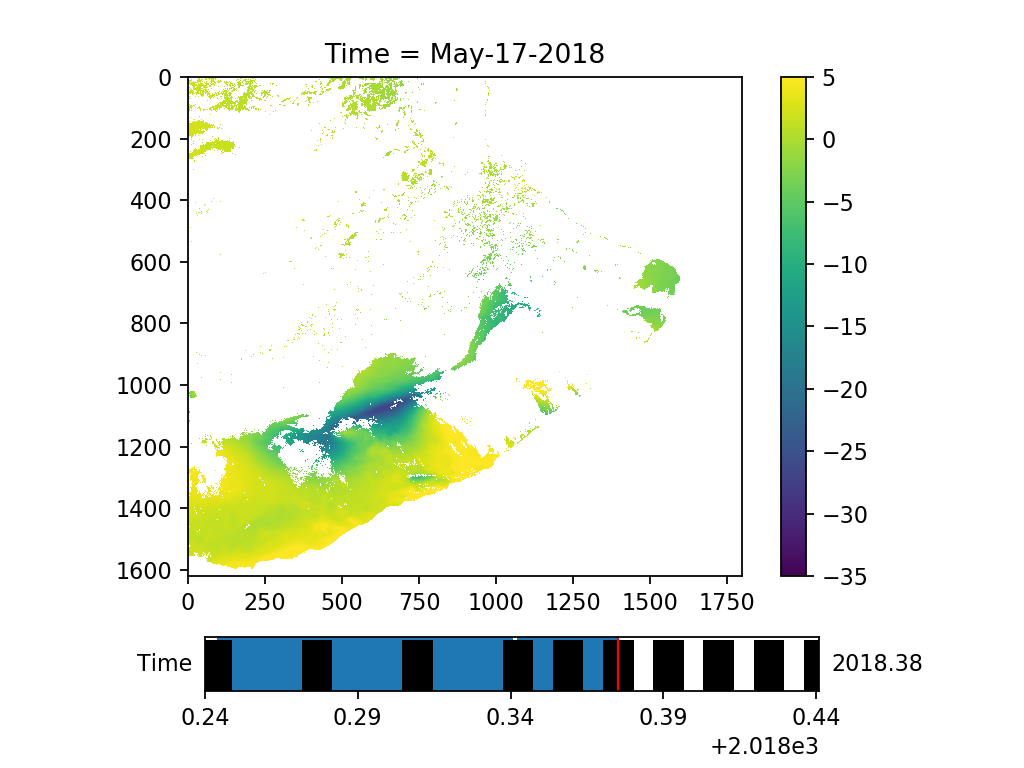

<IPython.core.display.Javascript object>


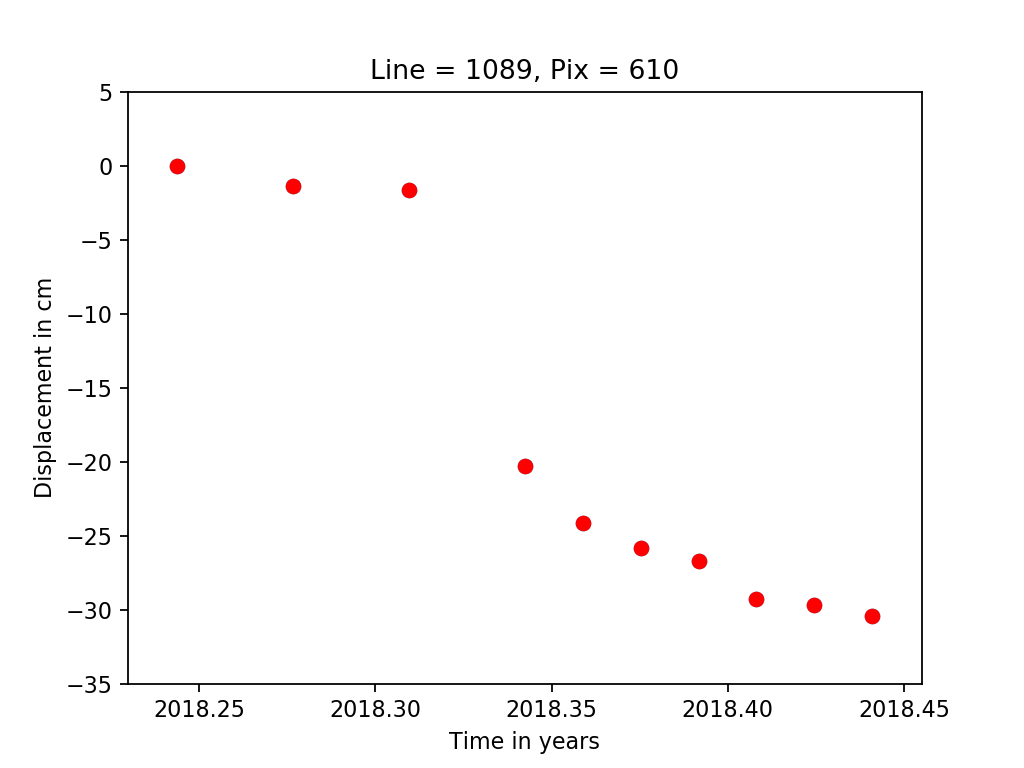

In [6]:
viewer = TimeSeriesViewer(filename='GRFN/GIAnT/Stack/TS-PARAMS.h5',
                          ylimits=[-35,5],
                          showraw=False)